# Лабораторна робота 2: Базові алгоритми навчання без учителя та обробка текстових даних (Scikit-learn lib)

**Виконав:** Бондар Петро


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Завдання 1: Зниження розмірності і візуалізація даних

### Вибір та завантаження датасету
Для виконання цієї лабораторної роботи було обрано датасет з лабораторної роботи 1 (оцінка рівнів ожиріння в людей з Мексико, Перу та Колумбії віком від 14 до 61).
Посилання на датасет: https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster

Виконаємо стандартну обробку датасету.

In [ ]:
df_obesity = pd.read_csv("data/ObesityDataSet.csv")
df_obesity = df_obesity.rename(columns={'family_history_with_overweight': 'FAM_OVERWEIGHT', 'NObeyesdad': 'Obesity_level'})
TARGET_VAR = 'Obesity_level'
OTHER_FEATURES = df_obesity.columns.drop(['Obesity_level'])

In [ ]:
df_obesity.keys()

## Завдання 2: Кластерний аналіз

In [34]:
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

In [35]:
image = Image.open('data/cyberpunk_city.jpg')
image_data_scaled = np.array(image, dtype=np.float64) / 255

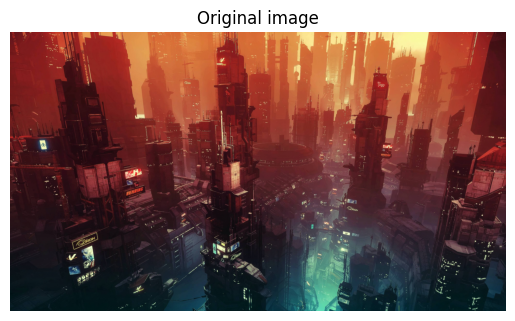

In [36]:
# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image")
plt.imshow(image_data_scaled)

In [37]:
w, h, d = original_shape = tuple(image_data_scaled.shape)
assert d == 3
image_array = np.reshape(image_data_scaled, (w * h, d))

[[0.78       0.42117647 0.26784314]
 [0.30381837 0.11971104 0.14097007]
 [0.65248869 0.25158371 0.18159879]
 [0.06042781 0.13547237 0.17611408]
 [0.36078431 0.57254902 0.50098039]
 [1.         0.86666667 0.6745098 ]
 [0.51848739 0.12422969 0.11708683]
 [0.32773109 0.20672269 0.25770308]
 [0.28657617 0.29864253 0.33514329]
 [0.15106209 0.05       0.07254902]
 [0.88851541 0.57927171 0.31148459]
 [0.50239651 0.1788671  0.18409586]
 [0.39448861 0.10609433 0.11149974]
 [0.15854342 0.20028011 0.25854342]
 [0.76666667 0.63529412 0.59411765]
 [0.07377451 0.05490196 0.07720588]
 [0.65975724 0.17535014 0.13501401]
 [0.51215686 0.33098039 0.33333333]
 [0.21013072 0.18202614 0.2130719 ]
 [0.79744246 0.3887468  0.21653879]
 [0.48039216 0.4754902  0.45686275]
 [0.77183601 0.34937611 0.21069519]
 [0.91294118 0.73490196 0.44156863]
 [0.32562542 0.08830291 0.09722786]
 [0.18431373 0.43529412 0.36862745]
 [0.03452685 0.10477408 0.13043478]
 [0.27127025 0.07519182 0.09070759]
 [0.17019608 0.12862745 0.16

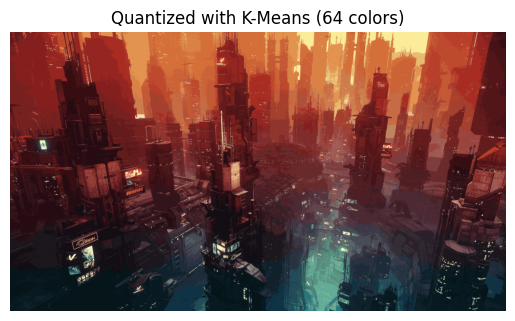

In [38]:
n_colors = 64

image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized with K-Means ({n_colors} colors)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

[[0.83212349 0.45874009 0.24689195]
 [0.22666667 0.12235294 0.14970588]
 [0.66741363 0.25004669 0.17684407]
 [0.0475817  0.1222658  0.15738562]
 [0.97647059 0.67843137 0.64313725]
 [0.29063181 0.41481481 0.4248366 ]
 [0.13461799 0.04962813 0.07207573]
 [0.52018454 0.1313341  0.12333718]
 [0.10010893 0.18779956 0.24793028]
 [0.31434469 0.08613691 0.09893361]
 [0.75630252 0.54005602 0.43305322]
 [0.35522876 0.53071895 0.48071895]
 [0.42491349 0.16793541 0.17093426]
 [0.29465241 0.28146168 0.32032086]
 [0.87741935 0.56318786 0.31486401]
 [0.96772247 0.9188537  0.65972851]
 [0.04184544 0.08272203 0.104406  ]
 [0.62443439 0.1670186  0.13474108]
 [0.52794118 0.38333333 0.37254902]
 [0.20836601 0.19581699 0.24418301]
 [0.40539216 0.10702614 0.10996732]
 [0.78431373 0.73803922 0.6172549 ]
 [0.13398693 0.29084967 0.34248366]
 [0.12941176 0.09685363 0.11600547]
 [0.30862745 0.16313725 0.20235294]
 [0.79103641 0.38422035 0.22203548]
 [0.52972136 0.21991744 0.21682147]
 [0.39372549 0.6745098  0.59

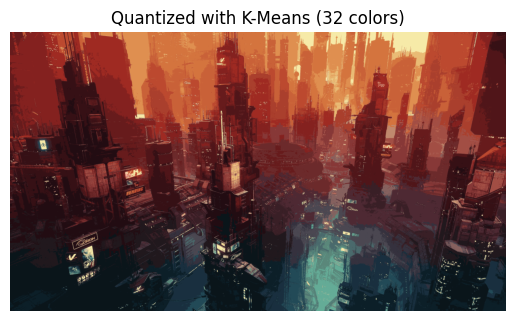

In [39]:
n_colors = 32

image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.figure(3)
plt.clf()
plt.axis("off")
plt.title(f"Quantized with K-Means ({n_colors} colors)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

[[0.80861713 0.41073271 0.22848297]
 [0.29839216 0.11529412 0.13631373]
 [0.56880985 0.27952576 0.26994984]
 [0.03736589 0.10192379 0.12848687]
 [0.90457516 0.73986928 0.53812636]
 [0.35822021 0.52307692 0.48853695]
 [0.55803471 0.15451882 0.13856209]
 [0.25661765 0.26446078 0.30923203]
 [0.11331071 0.06749623 0.08868778]
 [0.42154754 0.13341767 0.13641155]
 [0.86623094 0.54684096 0.30466231]
 [0.70080738 0.26620531 0.18229527]
 [0.95518207 0.91428571 0.66330532]
 [0.12762923 0.18669043 0.23885918]
 [0.75860566 0.56122004 0.46884532]
 [0.21231964 0.06944136 0.09019608]]


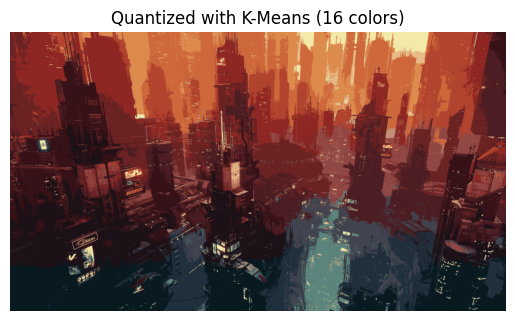

In [40]:
n_colors = 16

image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.figure(4)
plt.clf()
plt.axis("off")
plt.title(f"Quantized with K-Means ({n_colors} colors)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

[[0.83024261 0.47537388 0.27121967]
 [0.25956492 0.09115208 0.11120866]
 [0.67660352 0.27128614 0.20279163]
 [0.07891723 0.08665626 0.11162589]
 [0.92188235 0.82917647 0.61270588]
 [0.36052288 0.50352941 0.47490196]
 [0.48315966 0.14937815 0.14545658]
 [0.19212021 0.22100055 0.27084479]]


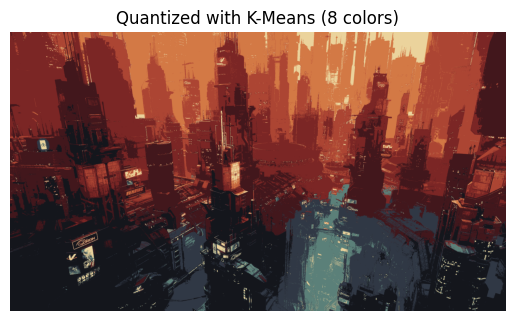

In [ ]:
n_colors = 8

image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.figure(5)
plt.clf()
plt.axis("off")
plt.title(f"Quantized with K-Means ({n_colors} colors)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

## Завдання 3: Обробка та класифікація текстових даних